In [1]:
using ForneyLab, Plots, LinearAlgebra, DelimitedFiles, DataFrames

┌ Info: Precompiling ForneyLab [9fc3f58a-c2cc-5bff-9419-6a294fefdca9]
└ @ Base loading.jl:1278
┌ Warning: Package ForneyLab does not have Flux in its dependencies:
│ - If you have ForneyLab checked out for development and have
│   added Flux as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ForneyLab
└ Loading Flux into ForneyLab from project dependency, future warnings for ForneyLab are suppressed.


In [2]:
#Generate data
using Random
import Distributions: pdf, MvNormal, rand

Random.seed!(1) # Set random seed

T = 40 # Number of timepoints

# Generative parameters
mu_0 = [8.0, 1.0] # Prior mean
V_0 = diagm(0=>ones(2)) # Prior covariance; diageye ensures an identity matrix of Diagonal type
F = [1.0 0.2; 
     -0.5 0.8] # Process matrix
H = [1.0 0.0; 
     0.0 1.0] # Observation matrix
Q = 1e-2*diagm(0=>ones(2)) # Process noise covariance
R = 1e-1*diagm(0=>ones(2)) # Observation noise covariance

# Data
x_hat = Vector{Vector{Float64}}(undef, T)
y_hat = Vector{Vector{Float64}}(undef, T)
prior_x = MvNormal(mu_0, V_0)
process_noise_dist = MvNormal(zeros(2), Q)
obs_noise_dist = MvNormal(zeros(2), R)

x_hat[1] = rand(prior_x)
y_hat[1] = H*x_hat[1] + rand(obs_noise_dist)
for t = 2:T
    x_hat[t] = F*x_hat[t-1] + rand(process_noise_dist) # Execute process
    y_hat[t] = H*x_hat[t] + rand(obs_noise_dist) # Draw observation
end
;

In [11]:
g = FactorGraph()

f(s,vec) = reshape(vec,(2,2))*s

# Pre-define vectors for storing latent and observed variables
x = Vector{Variable}(undef, T)
y = Vector{Variable}(undef, T)
mx = Vector{Variable}(undef, T-1)
a = Vector{Variable}(undef, T-1)

# Priors
@RV a_prior ~ GaussianMeanVariance(zeros(4),diagm(0=>ones(4)))
@RV x[1] ~ GaussianMeanVariance(mu_0, V_0)
@RV y[1] ~ GaussianMeanVariance(H*x[1], R) # Observation model
placeholder(y[1], :y, dims=(2,), index=1) # Indicate observed variable

for t = 2:T
    @RV a[t-1] ~ GaussianMeanVariance(a_prior, diagm(0=>1e-4*ones(4))) # to avoid loops
    #@RV mx[t-1] ~ Nonlinear{Sampling}(x[t-1],a[t-1],g=f,dims=[(2,),(2,),(4,)])
    @RV mx[t-1] ~ Nonlinear{Sampling}(x[t-1],a[t-1],g=f)
    @RV x[t] ~ GaussianMeanVariance(mx[t-1], Q) # Process model
    @RV y[t] ~ GaussianMeanVariance(H*x[t], R) # Observation model

    placeholder(y[t], :y, dims=(2,), index=t) # Indicate observed variable
end
;

In [12]:
# Define posterior factorization
pfz = PosteriorFactorization()
q_a = PosteriorFactor(a_prior, id=:A)
q_x = Vector{PosteriorFactor}(undef, T)
for t=1:T
    q_x[t] = PosteriorFactor(x[t],id=:X_*t)
end

In [13]:
# Compile algorithm
etime1 = @elapsed algo_mf = messagePassingAlgorithm(id=:MF, free_energy=true)

# Generate source code
etime2 = @elapsed code_mf = algorithmSourceCode(algo_mf, free_energy=true);

In [14]:
total_time = etime1 + etime2

26.031162665

In [15]:
# Load algorithm
eval(Meta.parse(code_mf))

# Initialize data
data = Dict(:y => y_hat)
n_its = 300

# Initial posterior factors
marginals_mf = Dict{Symbol, ProbabilityDistribution}()
marginals_mf[:a_prior] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(4), v=diagm(0=>ones(4)))
for t = 1:T
    marginals_mf[:x_*t] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(2), v=diagm(0=>ones(2)))
    if t != T
        #marginals_mf[:mx_*t] = vague(SampleList, (2,))
        marginals_mf[:mx_*t] = vague(SampleList, 2)
        marginals_mf[:a_*t] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=zeros(4), v=diagm(0=>ones(4)))
    end
end

msgX = Vector{Vector{Message}}(undef, T)
for k=1:T-1
    msgX[k] = init(:MFX_*k)
end
msgX[T] = Vector{Message}(undef,6)

# Run algorithm
F_mf = Vector{Float64}(undef, n_its)
F_x = Vector{Float64}(undef, n_its)
Time_mf = Vector{Float64}(undef, n_its)
for i = 1:n_its
    etime1 = @elapsed step!(:MFA, data, marginals_mf)
    
    etime2 = @elapsed for k = 1:T
        step!(:MFX_*k, data, marginals_mf, msgX[k])
    end
    total_time = total_time + etime1 + etime2
    if i == 50
        global F_est_50 = reshape(mean(marginals_mf[:a_prior]),(2,2))
    end
    F_mf[i] = freeEnergyMF(data, marginals_mf)
    Time_mf[i] = total_time
end
;

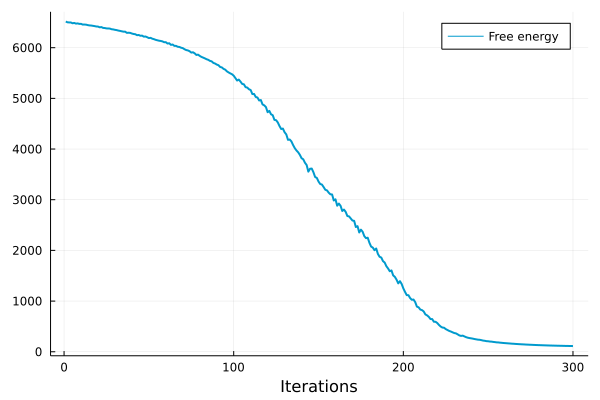

In [16]:
p = plot(F_mf, labels = "Free energy", color=:deepskyblue3, lw=2)
xlabel!("Iterations")
p

In [17]:
F_mf[end]

112.13006663025858

In [18]:
writedlm("FLFreeEnergy.txt", F_mf)
writedlm("FLFETime.txt", Time_mf)

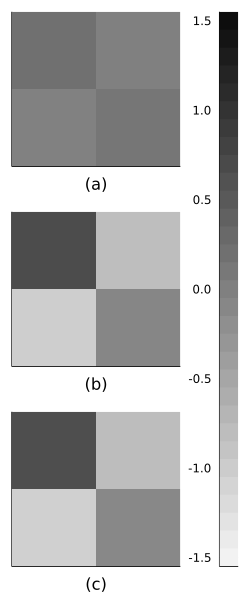

In [19]:
F_est = reshape(mean(marginals_mf[:a_prior]),(2,2))
hms = [heatmap(F_est_50, legend=:none, xticks=:none, yticks=:none, color=:greys, clims=(-1.5,1.5), xlabel="(a)"), 
       heatmap(F_est, legend=:none, xticks=:none, yticks=:none, color=:greys, clims=(-1.5,1.5), xlabel="(b)"), 
       heatmap(F, legend=:none, xticks=:none, yticks=:none, color=:greys, clims=(-1.5,1.5), xlabel="(c)")]

l = @layout[grid(3,1) a{0.1w}] # Stack a layout that rightmost one is for color bar
p = plot(hms..., heatmap(collect(1.5:-0.1:-1.5).*ones(31,1), legend=:none, xticks=:none, yticks=(1:5:31, string.(-1.5:0.5:1.5)), color=:grays), layout=l, size = (250, 600)) # Plot them set y values of color bar accordingly

In [20]:
savefig(p,"MatrixEstimate.pdf")